## Part 1 Build Dataset

In [1]:
import tools1
import pickle
import numpy as np

def make_sorted_list_and_save(days):
    pickle_in = open("stock_price_dict.pickle","rb")
    price_dict_ = pickle.load(pickle_in)
    #DATA_DIR = 'D:\Dataset\EarningsCallData\ReleasedDataset\ReleasedDataset_mp3'
    DATA_DIR = '.\EarningsCallData\ACL19_Release\ACL19_Release'
    stock_volatility_3days, text_all, date, company = tools1.calculate_volatility(price_dict_, days, DATA_DIR)
    print(len(stock_volatility_3days), len(text_all), len(date))

    combined_list = list(zip(date, stock_volatility_3days, company, text_all)) #进行数据的聚合、组合或并行处理。
    print(len(combined_list))
    sorted_list = sorted(combined_list, key=lambda x: x[0])#按照列表中元素的第一个索引（日期）进行排序

    np.save(f'sorted_list_{days}days.npy', sorted_list)

def make_and_save(days):
    make_sorted_list_and_save(days)

if __name__ == "__main__":
    print()
    make_and_save(3)

  6%|▌         | 33/572 [00:00<00:06, 81.79it/s]

Error Company: Aetna IncDate: 2017-01-31
Error Company: Aetna IncDate: 2017-05-02
Error Company: Aetna IncDate: 2017-10-31


 19%|█▊        | 106/572 [00:01<00:05, 85.41it/s]

Error Company: CA, Inc.Date: 2017-08-02


 98%|█████████▊| 558/572 [00:06<00:00, 85.20it/s]

Error Company: Vulcan MaterialsDate: 2017-08-02


100%|██████████| 572/572 [00:06<00:00, 82.57it/s]


5.129329438755057
563 563 563
563


## Part 2 Token-Level Encoder

In [2]:
import transformers
from tqdm import tqdm #用于在循环迭代中显示进度条的库
import torch

#Generate sentence representation 使用预训练的语言模型来计算文本的嵌入表示
def emb_str(text):
    input_ids = torch.tensor([tokenizer.encode(text)])[:,:512] #使用 tokenizer 对文本进行编码，将其转换为输入张量 input_ids。编码后的张量可能会被裁剪为最大长度512。
    # print(input_ids.shape)
    with torch.no_grad(): #是一个上下文管理器，用于在执行期间禁用梯度计算。在这个上下文中，所有的张量操作都不会被跟踪，也不会导致梯度被计算和存储。这在进行推断或评估时非常有用，因为在这些情况下通常不需要计算梯度。
        last_hidden_states = model(input_ids)[0]  # Models outputs are now tuples 使用模型对输入张量进行前向传递，获得最后一层隐藏状态 只取第一个元素
        emb = last_hidden_states.cpu().numpy() #将最后一层隐藏状态转移到 CPU 上，并将其转换为 NumPy 数组
    return emb

# Padding
def make(days,name):
    list = np.load(f"{name}_list_{days}days.npy")
    embs = []
    labels = []
    sentence_len = []
    for i in tqdm(range(len(list))):
        # print(list[i])
        text = (list[i][2] + "\n" + list[i][3]).split("\n")#company \n text contnent
        sentence_len.append(len(text))
        text_embs = emb_str(text)
        text_embs = np.squeeze(text_embs)#将 text_embs 中的单维度条目进行删除，以便在后续的处理中更方便地使用
        # text_embs = np.concatenate((text_embs, np.array([np.array(past_volatility_all[i])] * len(text_embs))), axis=1)
        embs.append(text_embs)
        labels.append(float(list[i][1]))#movement value->labels

    b = np.zeros([len(embs),len(max(embs,key = lambda x: len(x))),1024])#创建一个全零数组 b，形状为 (len(embs), max_sentence_len, 1024)，用于存储嵌入向量，并将嵌入向量复制到 b 中对应的位置
    for i,j in enumerate(embs):#使用 enumerate(embs) 遍历嵌入向量列表 embs，其中 i 是索引，j 是对应的嵌入向量
        b[i][0:len(j),:] = j #将嵌入向量 j 复制到数组 b 的对应位置。这里使用了切片操作 0:len(j) 来确保复制的部分与嵌入向量的长度一致
    print(b.shape)
    print(len(labels))

    np.save(f"{name}_embed_{days}days.npy", b)
    np.save(f"{name}_label_{days}days.npy", labels)

def make_emb(days):
    make(days, "sorted")

if __name__ == "__main__":
    print()
    model = transformers.BertModel.from_pretrained('./bert-large-uncased-whole-word-masking')#通过加载预训练的BERT模型来创建一个BERT模型实例
    tokenizer = transformers.BertTokenizer.from_pretrained('./bert-large-uncased-whole-word-masking')
    make_emb(3)

100%|██████████| 563/563 [14:07<00:00,  1.51s/it]


(563, 512, 1024)
563


## Part 3 Customized Sentence-level Transformer

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

import random, math

#### Example for single task

In [4]:
#给定的批量矩阵中进行遮蔽操作
def mask_(matrices, maskval=0.0, mask_diagonal=True):
    """
    Masks out all values in the given batch of matrices where i <= j holds,
    i < j if mask_diagonal is false

    In place operation

    :param tns:
    :return:
    """
    #在遮蔽过程中，矩阵中满足条件 i <= j（如果mask_diagonal为True）或 i < j（如果mask_diagonal为False）的元素将被遮蔽（置为指定的maskval值）。
    b, h, w = matrices.size()#函数的输入参数matrices是一个大小为 (batch_size, height, width) 的张量，表示一批矩阵。maskval参数是要用于遮蔽的值，默认为0.0。mask_diagonal参数控制是否遮蔽对角线上的元素，默认为True，即遮蔽对角线上的元素

    indices = torch.triu_indices(h, w, offset=0 if mask_diagonal else 1)#生成一个大小为 (2, num_indices) 的张量，其中 num_indices 是根据矩阵大小和遮蔽对角线的设置计算得到的索引数量。这个张量包含了上三角部分（包括或不包括对角线）的索引
    matrices[:, indices[0], indices[1]] = maskval #将遮蔽值 maskval 赋值给 matrices 张量中对应索引的位置。通过这样的操作，上三角部分的元素将被遮蔽（置为指定的遮蔽值），而下三角部分的元素将保持不变



def contains_nan(tensor):
    return bool((tensor != tensor).sum() > 0)#检查张量中是否包含NaN



# Self-Attention 自注意力机制是用于捕捉序列数据中不同位置之间的关联关系
class SelfAttention(nn.Module):
    def __init__(self, emb, heads=8, mask=False):
        """
        :param emb:
        :param heads:
        :param mask:
        """

        super().__init__()#表示调用 nn.Module 类的构造函数，用于初始化继承自 nn.Module 的子类的基本功能

        self.emb = emb
        self.heads = heads
        self.mask = mask

        self.tokeys = nn.Linear(emb, emb * heads, bias=False)
        self.toqueries = nn.Linear(emb, emb * heads, bias=False)
        self.tovalues = nn.Linear(emb, emb * heads, bias=False)#将输入 x 映射到键（keys）、查询（queries）和值（values）空间的线性变换

        self.unifyheads = nn.Linear(heads * emb, emb)#heads * emb 表示输入特征的大小，emb 表示输出特征的大小。

    def forward(self, x):#输入 x 的形状为 (b, t, e)，其中 b 是批量大小，t 是序列长度，e 是嵌入维度。首先，通过线性变换将输入分别映射到键、查询和值的空间，并将维度进行调整，使其适应自注意力计算的需求

        b, t, e = x.size()
        h = self.heads#在 SelfAttention 类的前向传播函数中，h = self.heads 是将类的 self.heads 属性赋值给局部变量 h。self.heads 表示模型中的注意力头数，而 h 则是用于表示头数的变量
        assert e == self.emb# 断言语句，用于检查变量 e 是否等于模型的 self.emb 属性. 如果断言条件为 False，则会触发断言错误，并抛出异常。

        keys    = self.tokeys(x)   .view(b, t, h, e)
        queries = self.toqueries(x).view(b, t, h, e)
        values  = self.tovalues(x) .view(b, t, h, e)#self.tovalues(x) 表示将输入张量 x 经过线性变换 self.tovalues，得到值表示，形状为 (b, t, h * e). b 表示批量大小，t 表示序列长度，h 表示注意力头数，e 表示特征维度。通过变换操作，将输入张量的特征维度转换为 (h * e)，并在维度上扩展为 (b, t, h, e) 的形状，以便后续的自注意力计算

        # compute scaled dot-product self-attention

        # - fold heads into the batch dimension
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, e)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, e)
        values = values.transpose(1, 2).contiguous().view(b * h, t, e)
        #首先，使用 transpose 将维度 1 和维度 2 进行转置，以便在后续计算中，序列长度 t 可以成为注意力矩阵的行数，而特征维度 e 可以成为注意力矩阵的列数。然后，使用 contiguous 确保张量在内存中是连续存储的
        #使用 view 将形状为 (b, h, t, e) 的张量重塑为形状为 (b * h, t, e) 的张量。这样做是为了将注意力头数 h 与批量大小 b 进行合并，形成一个新的批量维度
        queries = queries / (e ** (1/4))
        keys    = keys / (e ** (1/4))#对 queries 和 keys 进行缩放，除以 (e ** (1/4))，这是为了缩放注意力矩阵的值，使得在计算注意力概率时更稳定。
        # - Instead of dividing the dot products by sqrt(e), we scale the keys and values.
        #   This should be more memory efficient

        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2))#使用批量矩阵乘法 torch.bmm 计算查询向量和键向量之间的点积.点积操作会将查询向量的每个查询与键向量的每个键进行相乘，并将结果按键的维度进行求和。这将产生一个注意力矩阵，其形状为 (b * h, t, t)，其中每个元素表示查询与键之间的相似度或相关性

        assert dot.size() == (b*h, t, t)

        if self.mask: # mask out the lower half of the dot matrix,including the diagonal
            mask_(dot, maskval=float('-inf'), mask_diagonal=False) #如果 self.mask 为真，将屏蔽掉 dot 矩阵的下三角部分，包括对角线。mask_() 函数被用于执行屏蔽操作。

        dot = F.softmax(dot, dim=2) # dot now has row-wise self-attention probabilities 通过在维度2上对 dot 进行 softmax 操作，得到行级别的自注意力概率

        assert not contains_nan(dot[:, 1:, :]) # only the forst row may contain nan

        if self.mask == 'first':# 如果 self.mask 为 'first'，则将 dot 的第一行克隆为新的张量，并将其置为零。这是为了处理在 softmax 操作中可能导致除以零的情况，从而避免产生 NaN 值
            dot = dot.clone()
            dot[:, :1, :] = 0.0
            # - The first row of the first attention matrix is entirely masked out, so the softmax operation results
            #   in a division by zero. We set this row to zero by hand to get rid of the NaNs

        # apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, t, e) #自注意力概率矩阵 dot 与值矩阵 values 执行矩阵乘法，得到经过自注意力机制处理后的输出

        # swap h, t back, unify heads
        out = out.transpose(1, 2).contiguous().view(b, t, h * e) #通过交换 h 和 t 的顺序，并将头数 h 与特征维度 e 相乘，将输出 out 的形状转换为 (b, t, h * e)

        return self.unifyheads(out)


In [5]:
# Transformer Block

class TransformerBlock(nn.Module):#Transformer Block 是 Transformer 模型的基本构建块之一，它由自注意力层、前馈神经网络层和残差连接组成。
    def __init__(self, emb, heads, mask, seq_length, ff_hidden_mult=4, dropout=0.5):
        super().__init__()

        self.attention = SelfAttention(emb, heads=heads, mask=mask)#自注意力层，用于对输入进行自注意力计算
        self.mask = mask

        self.norm1 = nn.LayerNorm(emb)#两个 Layer Normalization 层，用于对自注意力层输出和前馈神经网络层输出进行归一化
        self.norm2 = nn.LayerNorm(emb)

        self.ff = nn.Sequential(
            nn.Linear(emb, ff_hidden_mult * emb),#线性变换层，它将输入的特征维度 emb 转换为 ff_hidden_mult * emb 的维度。
            nn.ReLU(), #这是一个 ReLU 激活函数，它对线性变换的输出进行非线性变换，引入非线性性质
            nn.Linear(ff_hidden_mult * emb, emb) #另一个线性变换层，它将前一层的输出维度 ff_hidden_mult * emb 转换回原始的特征维度 emb
        )#self.ff 是一个 nn.Sequential 对象，它定义了一个前馈神经网络层。这个前馈神经网络层由两个线性变换层和一个 ReLU 激活函数组成。通过这个前馈神经网络层，模型可以对输入的特征进行非线性变换和映射。这有助于模型学习更复杂的特征表示和抽象
        #因为在 Transformer 模型中的每个编码层中，存在一个前馈神经网络（Feed-Forward Neural Network）层，用于引入非线性性质和增加模型的表示能力。该前馈神经网络层通常由两个线性变换（nn.Linear）和一个非线性激活函数（如 ReLU）组成。
        #在该前馈神经网络层中，将输入特征的维度从 emb 转换为 ff_hidden_mult * emb，其中 ff_hidden_mult 是一个超参数，通常设置为大于 1 的值。这样做的目的是通过引入更高维度的表示空间和非线性变换，使模型能够学习更复杂的特征和模式。
        #在前馈神经网络层后面，通过另一个线性变换将维度从 ff_hidden_mult * emb 转换回原始的特征维度 emb。这样做是为了保持编码层的输出与输入的维度一致，以便能够进行残差连接（residual connection），从而更好地传递和保留原始输入的信息。
        #通过引入非线性性质和通过线性变换改变特征维度的方式，前馈神经网络层在编码层中增加了模型的非线性表示能力，同时保持了输入和输出的一致性，有助于模型进行更高级的特征提取和表示学习。
        
        self.do = nn.Dropout(dropout)# Dropout 层，用于在训练过程中进行随机失活以防止过拟合。

    def forward(self, x):#定义了 TransformerBlock 的前向传播过程。

        attended = self.attention(x) #将输入 x 传递给自注意力层（self.attention），以计算自注意力概率矩阵

        x = self.norm1(attended + x) #将自注意力层的输出（attended）与输入 x 相加，并应用层归一化（self.norm1）来得到规范化后的输出

        x = self.do(x) #应用丢弃（dropout）操作（self.do）来对输出进行正则化，防止过拟合

        fedforward = self.ff(x)#将前一步骤的输出 x 传递给前馈神经网络层（self.ff），进行非线性变换

        x = self.norm2(fedforward + x)#将前馈神经网络层的输出（fedforward）与之前的输出 x 相加，并再次应用层归一化

        x = self.do(x)

        return x
    #通过以上步骤，TransformerBlock 实现了一个 Transformer 模型中的一个编码层，其中包括了自注意力机制、前馈神经网络和残差连接。这些操作有助于模型进行特征提取和表示学习，从而实现对输入序列的编码


In [6]:
##RTransformer 序列回归

class RTransformer(nn.Module):
    """
    Transformer for sequences Regression    
    
    """

    def __init__(self, emb, heads, depth, seq_length, num_tokens, num_classes, max_pool=True, dropout=0.0):
        """
        :param emb: Embedding dimension
        :param heads: nr. of attention heads
        :param depth: Number of transformer blocks
        :param seq_length: Expected maximum sequence length
        :param num_tokens: Number of tokens (usually words) in the vocabulary
        :param num_classes: Number of classes.
        :param max_pool: If true, use global max pooling in the last layer. If false, use global
                         average pooling.
        """
        super().__init__()

        self.num_tokens, self.max_pool = num_tokens, max_pool

        #self.token_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=num_tokens) 词嵌入层（Token Embedding）：该层将输入的词索引映射到连续的向量表示，即词嵌入。这种嵌入通常使用一个 nn.Embedding 层实现，其中 embedding_dim 参数指定了词嵌入的维度，而 num_embeddings 参数表示词汇表中的单词数量。
        self.pos_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=seq_length)#位置嵌入层（Position Embedding）：由于 Transformer 模型没有显式的位置信息，为了引入序列中每个位置的相对位置信息，使用了位置嵌入。该层将输入序列的位置索引映射为相应的位置嵌入向量。在这个模型中，使用了一个 nn.Embedding 层来实现位置嵌入，其中 embedding_dim 参数指定了位置嵌入的维度，而 num_embeddings 参数表示序列的最大长度。

        tblocks = []#在这段代码中，通过一个循环，将多个 TransformerBlock 实例化并添加到 tblocks 列表中。这个循环的次数由参数 depth 控制，表示模型中 TransformerBlock 的层数
        for i in range(depth):
            tblocks.append(
                TransformerBlock(emb=emb, heads=heads, seq_length=seq_length, mask=False, dropout=dropout))

        self.tblocks = nn.Sequential(*tblocks)#通过 nn.Sequential 将 tblocks 列表中的多个 TransformerBlock 组合成一个串行的模型结构，即 self.tblocks。这样做可以方便地将输入按顺序通过所有的 TransformerBlock 进行处理。

        self.toprobs = nn.Linear(emb, num_classes)#通过 nn.Linear 层（self.toprobs）将最后一个 TransformerBlock 的输出映射到预测的目标类别数量（num_classes）。这个线性层将输出的特征维度（emb）转换为目标类别的数量，以便进行后续的分类操作。

        self.do = nn.Dropout(dropout)

    def forward(self, x):
        """
        :param x: A batch by sequence length integer tensor of token indices.
        :return: predicted log-probability vectors for each token based on the preceding tokens.
        """
        #参数 x 是一个批次（batch）大小乘以序列长度的整数张量，表示输入的令牌索引。模型的目标是基于先前的令牌预测每个令牌的对数概率向量
        sentences_emb = x#将输入 x 赋值给 sentences_emb 变量，表示输入的句子嵌入
        b, t, e = x.size()

        positions = self.pos_embedding(torch.arange(t))[None, :, :].expand(b, t, e)#对序列长度的范围进行嵌入，获取位置编码。位置编码的目的是为了在输入序列中引入每个令牌的位置信息。
        #positions = torch.tensor(positions, dtype=torch.float32)
        x = sentences_emb + positions#将位置编码添加到输入的句子嵌入中，以获得具有位置信息的句子表示
        x = self.do(x)

        x = self.tblocks(x)#每个 TransformerBlock 都会对输入序列进行自注意力计算和前馈神经网络操作，以获取更好的表示

        x = x.max(dim=1)[0] if self.max_pool else x.mean(dim=1) # pool over the time dimension 对序列的时间维度进行池化操作，得到一个固定长度的向量表示。max_pool 池化操作选择最大值，mean_pool 池化操作选择平均值。
        x = self.toprobs(x)#通过 self.toprobs 对输入 x 进行线性变换，将其映射到预测类别的空间。
        x = torch.squeeze(x)#将张量 x 去除维度为1的尺寸，使其变为一维张量。这通常是为了消除不必要的尺寸，以便与预期的输出形状相匹配。在这里，x 是预测的对数概率向量，去除维度为1的尺寸后，得到的张量表示每个预测类别的对数概率。

        return x

In [7]:
# Format Dataset

from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, texts, labels):
        'Initialization'
        self.labels = labels
        self.text = texts

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        if torch.is_tensor(index):
            index = index.tolist()#您检查index是否是一个张量对象，如果是，您将其转换为Python列表。这是为了兼容处理张量索引和标量索引的情况。

        # Load data and get label
        X = self.text[index,:,:]
        y = self.labels[index]

        return X, y

In [8]:
import numpy as np
# Load your own the whole dataset
TEXT_emb = np.load("sorted_embed_3days.npy")
LABEL_emb = np.load("sorted_label_3days.npy")

## Part 3 Build the Predictor

In [9]:
# Main function

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np

from argparse import ArgumentParser
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import random, sys, math, gzip

from tqdm import tqdm
from tqdm import tqdm_notebook
import time
import matplotlib.pyplot as plt

NUM_CLS = 1

def go(arg):
    """
    Creates and trains a basic transformer for any regression task.
    """

    if arg.final:#arg.final 为真,按照 8:2 的比例划分为训练集和验证集。

        train, val = train_test_split(TEXT_emb, test_size=0.2)
        train_label, val_label = train_test_split(LABEL_emb, test_size=0.2)
        training_set = Dataset(train, train_label)#使用 torch.utils.data.DataLoader 创建了训练集和验证集的数据加载器，用于批量加载数据进行训练和评估。
        val_set = Dataset(val, val_label)

    else:
        train, val = train_test_split(TEXT_emb, test_size=0.2)
        train_label, val_label = train_test_split(LABEL_emb, test_size=0.2)
        train, val = train_test_split(train, test_size=0.2)#当 arg.final 为假时，即非最终情况，首先进行一次训练集和验证集的划分，然后再次对训练集和验证集进行划分的目的是为了创建更小的训练集和验证集.这种两次划分的方式可以帮助在较小的数据集上进行快速实验和调试，从而更高效地调整模型的超参数、模型结构等，以达到更好的性能和泛化能力
        train_label, val_label = train_test_split(train_label, test_size=0.2)

        training_set = Dataset(train, train_label)
        val_set = Dataset(val, val_label)

    trainloader=torch.utils.data.DataLoader(training_set, batch_size=arg.batch_size, shuffle=False, num_workers=0)#trainloader是训练集的数据加载器，它会从training_set中按照batch_size指定的批量大小取出数据进行训练。shuffle=False表示不对数据进行随机重排，num_workers=0表示在主进程中加载数据
    testloader=torch.utils.data.DataLoader(val_set, batch_size=len(val_set), shuffle=False, num_workers=0)
    print('training examples', len(training_set))
    #print(f'- nr. of {"test" if arg.final else "validation"} examples {len(test_iter)}')

    if arg.final:
          print('test examples', len(val_set))
    else:
          print('validation examples', len(val_set))
    #如果arg.final为True，则表示当前是最终的测试阶段，使用的是测试集。因此，打印语句print('test examples', len(val_set))输出测试集的样本数量。
    #如果arg.final为False，则表示当前是验证阶段，使用的是验证集。因此，打印语句print('validation examples', len(val_set))输出验证集的样本数量。

    # create the model
    model = RTransformer(emb=arg.embedding_size, heads=arg.num_heads, depth=arg.depth, \
                         seq_length=arg.max_length, num_tokens=arg.vocab_size, num_classes=NUM_CLS, max_pool=arg.max_pool)
    #     if torch.cuda.is_available():
    #         model.cuda()

    opt = torch.optim.Adam(lr=arg.lr, params=model.parameters())#使用Adam优化器进行参数优化，其中学习率由arg.lr指定

    # training loop
    start_time = time.time()
    seen = 0#记录已经处理的样本数
    evaluation= {'epoch': [] ,'Train Accuracy': [], 'Test Accuracy' :[]}#epoch用于记录训练的轮数，Train Accuracy用于记录每轮训练后模型在训练集上的准确率，Test Accuracy用于记录每轮训练后模型在测试集上的准确率。
    for e in tqdm_notebook(range(arg.num_epochs)):
        train_loss_tol = 0.0
        print('\n epoch ' ,e)
        model.train(True)#启用训练模式

        for i, data in tqdm_notebook(enumerate(trainloader)):
            if i > 2:
                break
            # learning rate warmup学习率预热
            # - we linearly increase the learning rate from 10e-10 to arg.lr over the first
            #   few thousand batches
            if arg.lr_warmup > 0 and seen < arg.lr_warmup:
                lr = max((arg.lr / arg.lr_warmup) * seen, 1e-10)
                opt.lr = lr

            opt.zero_grad()#清零优化器的梯度

            inputs, labels = data
            inputs = Variable(inputs.type(torch.FloatTensor))#将输入数据转换为FloatTensor类型，并将其封装在Variable中（用于自动求导）
            # labels = torch.tensor(labels, dtype=torch.float32)
            labels = labels.clone().detach()#克隆并分离标签，并将其转换为浮点型
            if inputs.size(1) > arg.max_length:
                inputs = inputs[:, :arg.max_length, :]#如果输入数据的长度超过了arg.max_length，则进行截断处理
            out = model(inputs)
            out = torch.unsqueeze(out, 0)
            # print(out)
            out = out.float()
            labels = labels.float()

            # print(out.shape,labels.shape)

            loss = F.mse_loss(out, labels)#计算损失函数（均方误差损失）
            train_loss_tol += loss#累加训练损失

            loss.backward()#反向传播计算梯度

            # clip gradients
            # - If the total gradient vector has a length > 1, we clip it back down to 1.
            if arg.gradient_clipping > 0.0:
                nn.utils.clip_grad_norm_(model.parameters(), arg.gradient_clipping)#调用nn.utils.clip_grad_norm_函数，传入模型的参数和梯度裁剪阈值作为参数，对模型的梯度进行裁剪。裁剪操作的目的是限制梯度的范数，以防止梯度爆炸的问题

            opt.step()#更新模型的参数

            seen += inputs.size(0)#更新迭代次数seen,增加当前批次的样本数量
            # tbw.add_scalar('classification/train-loss', float(loss.item()), seen)
        # print('train_loss: ',train_loss_tol)
        train_loss_tol = train_loss_tol /( i +1)#计算训练损失的平均值
        training_time = time.time()-start_time
        print("Training time: {}".format(training_time))
        with torch.no_grad():#上下文管理器，表示接下来的计算不会对梯度产生影响

            model.train(False)#进入评估模式
            tot, cor= 0.0, 0.0

            loss_test = 0.0#初始化测试集的损失loss_test为0.0
            for i, data in tqdm_notebook(enumerate(testloader)):
                if i > 2:
                    break
                inputs, labels = data
                inputs, labels = torch.tensor(inputs, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)
                if inputs.size(1) > arg.max_length:
                    inputs = inputs[:, :arg.max_length, :]
                out = model(inputs)

                loss_test += F.mse_loss(out, labels)#计算预测结果与真实标签之间的均方误差损失，并累加到loss_test中
                # tot = float(inputs.size(0))
                # cor += float(labels.sum().item())

            acc = loss_test.numpy()
            training_time = time.time()-start_time
            print("Training time: {}".format(training_time))
            if arg.final:
                print('test accuracy', acc)
            else:
                print('validation accuracy', acc)#准确率计算实际上是损失值而不是准确率

        #torch.save(model, './checkpoint/epoch' +str(e) +'.pth')
        torch.save(model, '\\Users\\zc22364\\Downloads\\HTML_partial_reproduction-main\\HTML_partial_reproduction-main\\checkpoint\\epoch' +str(e) +'.pth')
        # print(train_loss_tol)
        # print(acc)
        train_loss_tol = train_loss_tol.detach().numpy()
        evaluation['epoch'].append(e)
        evaluation['Train Accuracy'].append(train_loss_tol)#实际上存储的是训练集的损失值
        evaluation['Test Accuracy'].append(acc)#测试集/验证集的准确率


    evaluation = pd.DataFrame(evaluation)
    evaluation.sort_values(["Test Accuracy"] ,ascending=True ,inplace=True)

    return evaluation
    # tbw.add_scalar('classification/test-loss', float(loss.item()), e)

  

###### Run

training examples 360
validation examples 90


c:\Users\zc22364\AppData\Local\anaconda3\envs\finbert\lib\site-packages\ipykernel_launcher.py:69: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\zc22364\AppData\Local\anaconda3\envs\finbert\lib\site-packages\ipykernel_launcher.py:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



 epoch  0


0it [00:00, ?it/s]

Training time: 6.0894598960876465


c:\Users\zc22364\AppData\Local\anaconda3\envs\finbert\lib\site-packages\ipykernel_launcher.py:124: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

c:\Users\zc22364\AppData\Local\anaconda3\envs\finbert\lib\site-packages\ipykernel_launcher.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Training time: 46.00340938568115
validation accuracy 0.77922684

 epoch  1


0it [00:00, ?it/s]

Training time: 50.794535636901855


0it [00:00, ?it/s]

Training time: 80.8565936088562
validation accuracy 32.604725

 epoch  2


0it [00:00, ?it/s]

Training time: 85.47351264953613


0it [00:00, ?it/s]

Training time: 115.16620445251465
validation accuracy 0.7773431

 epoch  3


0it [00:00, ?it/s]

Training time: 120.85638546943665


0it [00:00, ?it/s]

Training time: 152.61782932281494
validation accuracy 6.810984

 epoch  4


0it [00:00, ?it/s]

Training time: 157.3472592830658


0it [00:00, ?it/s]

Training time: 184.2618749141693
validation accuracy 3.061255

 epoch  5


0it [00:00, ?it/s]

Training time: 189.24164581298828


0it [00:00, ?it/s]

Training time: 220.5497760772705
validation accuracy 0.81758463

 epoch  6


0it [00:00, ?it/s]

Training time: 225.37289118766785


0it [00:00, ?it/s]

Training time: 254.35173392295837
validation accuracy 1.5746344

 epoch  7


0it [00:00, ?it/s]

Training time: 259.2272343635559


0it [00:00, ?it/s]

Training time: 288.9909975528717
validation accuracy 0.72189134

 epoch  8


0it [00:00, ?it/s]

Training time: 293.58676862716675


0it [00:00, ?it/s]

Training time: 323.3102366924286
validation accuracy 1.0227128

 epoch  9


0it [00:00, ?it/s]

Training time: 328.40693712234497


0it [00:00, ?it/s]

Training time: 357.703786611557
validation accuracy 0.76012695

 epoch  10


0it [00:00, ?it/s]

Training time: 362.51443243026733


0it [00:00, ?it/s]

Training time: 392.4398844242096
validation accuracy 0.7150256

 epoch  11


0it [00:00, ?it/s]

Training time: 397.22440004348755


0it [00:00, ?it/s]

Training time: 427.61933946609497
validation accuracy 0.76912427

 epoch  12


0it [00:00, ?it/s]

Training time: 432.7716188430786


0it [00:00, ?it/s]

Training time: 464.41546607017517
validation accuracy 0.7989852

 epoch  13


0it [00:00, ?it/s]

Training time: 469.3691453933716


0it [00:00, ?it/s]

Training time: 497.63950300216675
validation accuracy 0.7187004

 epoch  14


0it [00:00, ?it/s]

Training time: 502.4917256832123


0it [00:00, ?it/s]

Training time: 535.8711361885071
validation accuracy 0.68670297

 epoch  15


0it [00:00, ?it/s]

Training time: 541.1079216003418


0it [00:00, ?it/s]

Training time: 570.5706775188446
validation accuracy 0.83923906

 epoch  16


0it [00:00, ?it/s]

Training time: 575.6318998336792


0it [00:00, ?it/s]

Training time: 608.182959318161
validation accuracy 0.69986665

 epoch  17


0it [00:00, ?it/s]

Training time: 613.440107345581


0it [00:00, ?it/s]

Training time: 643.3787488937378
validation accuracy 0.6860269

 epoch  18


0it [00:00, ?it/s]

Training time: 648.4553046226501


0it [00:00, ?it/s]

Training time: 681.7448770999908
validation accuracy 0.75610316

 epoch  19


0it [00:00, ?it/s]

Training time: 686.5817966461182


0it [00:00, ?it/s]

Training time: 716.3493468761444
validation accuracy 0.6990803

 epoch  20


0it [00:00, ?it/s]

Training time: 721.7561390399933


0it [00:00, ?it/s]

Training time: 754.0906734466553
validation accuracy 0.696269

 epoch  21


0it [00:00, ?it/s]

Training time: 759.084924697876


0it [00:00, ?it/s]

Training time: 791.2961297035217
validation accuracy 0.6857847

 epoch  22


0it [00:00, ?it/s]

Training time: 796.608855009079


0it [00:00, ?it/s]

Training time: 826.2017407417297
validation accuracy 0.71178055

 epoch  23


0it [00:00, ?it/s]

Training time: 831.5802173614502


0it [00:00, ?it/s]

Training time: 864.4441480636597
validation accuracy 0.6874526

 epoch  24


0it [00:00, ?it/s]

Training time: 869.0491054058075


0it [00:00, ?it/s]

Training time: 899.0891220569611
validation accuracy 0.7240041

 epoch  25


0it [00:00, ?it/s]

Training time: 904.5175316333771


0it [00:00, ?it/s]

Training time: 936.4668591022491
validation accuracy 0.69019914

 epoch  26


0it [00:00, ?it/s]

Training time: 941.4584276676178


0it [00:00, ?it/s]

Training time: 972.1002140045166
validation accuracy 0.69728816

 epoch  27


0it [00:00, ?it/s]

Training time: 977.522501707077


0it [00:00, ?it/s]

Training time: 1017.5829977989197
validation accuracy 0.6873882

 epoch  28


0it [00:00, ?it/s]

Training time: 1023.6847422122955


0it [00:00, ?it/s]

Training time: 1060.2914323806763
validation accuracy 0.76754564

 epoch  29


0it [00:00, ?it/s]

Training time: 1066.305741071701


0it [00:00, ?it/s]

Training time: 1103.2022755146027
validation accuracy 0.70008683

 epoch  30


0it [00:00, ?it/s]

Training time: 1108.8410444259644


0it [00:00, ?it/s]

Training time: 1148.6734323501587
validation accuracy 0.6904507

 epoch  31


0it [00:00, ?it/s]

Training time: 1154.6770594120026


0it [00:00, ?it/s]

Training time: 1192.7568917274475
validation accuracy 0.7685989

 epoch  32


0it [00:00, ?it/s]

Training time: 1199.263061285019


0it [00:00, ?it/s]

Training time: 1236.2123663425446
validation accuracy 0.70359325

 epoch  33


0it [00:00, ?it/s]

Training time: 1242.6489260196686


0it [00:00, ?it/s]

Training time: 1280.8580448627472
validation accuracy 0.7010139

 epoch  34


0it [00:00, ?it/s]

Training time: 1287.1476829051971


0it [00:00, ?it/s]

Training time: 1326.1649158000946
validation accuracy 0.68599135

 epoch  35


0it [00:00, ?it/s]

Training time: 1332.63583111763


0it [00:00, ?it/s]

Training time: 1370.191670179367
validation accuracy 0.7220495

 epoch  36


0it [00:00, ?it/s]

Training time: 1377.0662145614624


0it [00:00, ?it/s]

Training time: 1413.796796321869
validation accuracy 0.6900389

 epoch  37


0it [00:00, ?it/s]

Training time: 1420.7608153820038


0it [00:00, ?it/s]

Training time: 1458.8865361213684
validation accuracy 0.68665665

 epoch  38


0it [00:00, ?it/s]

Training time: 1464.820850610733


0it [00:00, ?it/s]

Training time: 1503.5719075202942
validation accuracy 0.7535734

 epoch  39


0it [00:00, ?it/s]

Training time: 1509.8246638774872


0it [00:00, ?it/s]

Training time: 1548.6180169582367
validation accuracy 0.7161125

 epoch  40


0it [00:00, ?it/s]

Training time: 1554.6070075035095


0it [00:00, ?it/s]

Training time: 1591.9227030277252
validation accuracy 0.70692116

 epoch  41


0it [00:00, ?it/s]

Training time: 1598.6570672988892


0it [00:00, ?it/s]

Training time: 1635.891924381256
validation accuracy 0.7446428

 epoch  42


0it [00:00, ?it/s]

Training time: 1642.214572429657


0it [00:00, ?it/s]

Training time: 1680.0816278457642
validation accuracy 0.7414198

 epoch  43


0it [00:00, ?it/s]

Training time: 1686.2632966041565


0it [00:00, ?it/s]

Training time: 1725.4472460746765
validation accuracy 0.6857736

 epoch  44


0it [00:00, ?it/s]

Training time: 1731.5311634540558


0it [00:00, ?it/s]

Training time: 1764.0335292816162
validation accuracy 0.73818904

 epoch  45


0it [00:00, ?it/s]

Training time: 1768.293967962265


0it [00:00, ?it/s]

Training time: 1794.980226278305
validation accuracy 0.7064137

 epoch  46


0it [00:00, ?it/s]

Training time: 1800.6971504688263


0it [00:00, ?it/s]

Training time: 1834.0897266864777
validation accuracy 0.6976867

 epoch  47


0it [00:00, ?it/s]

Training time: 1839.2872231006622


0it [00:00, ?it/s]

Training time: 1867.607248544693
validation accuracy 0.68679893

 epoch  48


0it [00:00, ?it/s]

Training time: 1872.420444726944


0it [00:00, ?it/s]

Training time: 1904.6506888866425
validation accuracy 0.81610465

 epoch  49


0it [00:00, ?it/s]

Training time: 1909.5604062080383


0it [00:00, ?it/s]

Training time: 1937.4611511230469
validation accuracy 0.74509776

 epoch  50


0it [00:00, ?it/s]

Training time: 1942.1202116012573


0it [00:00, ?it/s]

Training time: 1973.2184941768646
validation accuracy 0.68894464

 epoch  51


0it [00:00, ?it/s]

Training time: 1978.357103586197


0it [00:00, ?it/s]

Training time: 2006.6250929832458
validation accuracy 0.7740292

 epoch  52


0it [00:00, ?it/s]

Training time: 2012.1254951953888


0it [00:00, ?it/s]

Training time: 2045.877125263214
validation accuracy 0.70546496

 epoch  53


0it [00:00, ?it/s]

Training time: 2051.1122221946716


0it [00:00, ?it/s]

Training time: 2081.1820664405823
validation accuracy 0.701911

 epoch  54


0it [00:00, ?it/s]

Training time: 2086.766360759735


0it [00:00, ?it/s]

Training time: 2119.844893217087
validation accuracy 0.686058

 epoch  55


0it [00:00, ?it/s]

Training time: 2124.636220932007


0it [00:00, ?it/s]

Training time: 2155.953696012497
validation accuracy 0.7212771

 epoch  56


0it [00:00, ?it/s]

Training time: 2161.3735547065735


0it [00:00, ?it/s]

Training time: 2193.009854078293
validation accuracy 0.690053

 epoch  57


0it [00:00, ?it/s]

Training time: 2198.138102054596


0it [00:00, ?it/s]

Training time: 2232.2974672317505
validation accuracy 0.6868036

 epoch  58


0it [00:00, ?it/s]

Training time: 2237.671961545944


0it [00:00, ?it/s]

Training time: 2268.9126019477844
validation accuracy 0.7520989

 epoch  59


0it [00:00, ?it/s]

Training time: 2275.285579442978


0it [00:00, ?it/s]

Training time: 2314.6172523498535
validation accuracy 0.71659595

 epoch  60


0it [00:00, ?it/s]

Training time: 2321.4498529434204


0it [00:00, ?it/s]

Training time: 2359.780586719513
validation accuracy 0.70275444

 epoch  61


0it [00:00, ?it/s]

Training time: 2365.863294363022


0it [00:00, ?it/s]

Training time: 2406.0768399238586
validation accuracy 0.7447036

 epoch  62


0it [00:00, ?it/s]

Training time: 2412.751673936844


0it [00:00, ?it/s]

Training time: 2451.65789937973
validation accuracy 0.74218434

 epoch  63


0it [00:00, ?it/s]

Training time: 2458.283254146576


0it [00:00, ?it/s]

Training time: 2495.334486722946
validation accuracy 0.6957711

 epoch  64


0it [00:00, ?it/s]

Training time: 2501.705644607544


0it [00:00, ?it/s]

Training time: 2541.6146910190582
validation accuracy 0.79692847

 epoch  65


0it [00:00, ?it/s]

Training time: 2547.744868040085


0it [00:00, ?it/s]

Training time: 2587.5608530044556
validation accuracy 0.8276262

 epoch  66


0it [00:00, ?it/s]

Training time: 2594.1213665008545


0it [00:00, ?it/s]

Training time: 2631.7637798786163
validation accuracy 0.7024008

 epoch  67


0it [00:00, ?it/s]

Training time: 2638.6392097473145


0it [00:00, ?it/s]

Training time: 2676.774211883545
validation accuracy 0.69214153

 epoch  68


0it [00:00, ?it/s]

Training time: 2682.459895849228


0it [00:00, ?it/s]

Training time: 2722.5250408649445
validation accuracy 0.73033327

 epoch  69


0it [00:00, ?it/s]

Training time: 2728.7184455394745


0it [00:00, ?it/s]

Training time: 2767.1130063533783
validation accuracy 0.69113684

 epoch  70


0it [00:00, ?it/s]

Training time: 2773.99236369133


0it [00:00, ?it/s]

Training time: 2811.7442638874054
validation accuracy 0.7432414

 epoch  71


0it [00:00, ?it/s]

Training time: 2818.015887737274


0it [00:00, ?it/s]

Training time: 2858.169867992401
validation accuracy 0.6953968

 epoch  72


0it [00:00, ?it/s]

Training time: 2864.543691635132


0it [00:00, ?it/s]

Training time: 2904.5572011470795
validation accuracy 0.7264864

 epoch  73


0it [00:00, ?it/s]

Training time: 2910.764481782913


0it [00:00, ?it/s]

Training time: 2948.30717086792
validation accuracy 0.76246864

 epoch  74


0it [00:00, ?it/s]

Training time: 2955.2390949726105


0it [00:00, ?it/s]

Training time: 2995.5454370975494
validation accuracy 0.82053834

 epoch  75


0it [00:00, ?it/s]

Training time: 3003.2920150756836


0it [00:00, ?it/s]

Training time: 3040.707769393921
validation accuracy 0.690914

 epoch  76


0it [00:00, ?it/s]

Training time: 3052.7824053764343


0it [00:00, ?it/s]

Training time: 3084.033982038498
validation accuracy 0.70779604

 epoch  77


0it [00:00, ?it/s]

Training time: 3094.5906319618225


0it [00:00, ?it/s]

Training time: 3127.6497435569763
validation accuracy 0.7347224

 epoch  78


0it [00:00, ?it/s]

Training time: 3137.7024092674255


0it [00:00, ?it/s]

Training time: 3174.518155813217
validation accuracy 0.6885233

 epoch  79


0it [00:00, ?it/s]

Training time: 3182.8724629879


0it [00:00, ?it/s]

Training time: 3218.1914446353912
validation accuracy 0.70947003

 epoch  80


0it [00:00, ?it/s]

Training time: 3227.9818046092987


0it [00:00, ?it/s]

Training time: 3262.981594800949
validation accuracy 0.68549603

 epoch  81


0it [00:00, ?it/s]

Training time: 3274.1263344287872


0it [00:00, ?it/s]

Training time: 3305.985146045685
validation accuracy 0.7136704

 epoch  82


0it [00:00, ?it/s]

Training time: 3317.7335062026978


0it [00:00, ?it/s]

Training time: 3347.7841353416443
validation accuracy 0.692796

 epoch  83


0it [00:00, ?it/s]

Training time: 3359.369062423706


0it [00:00, ?it/s]

Training time: 3388.105595111847
validation accuracy 0.70270807

 epoch  84


0it [00:00, ?it/s]

Training time: 3397.4351987838745


0it [00:00, ?it/s]

Training time: 3423.587963581085
validation accuracy 0.69128364

 epoch  85


0it [00:00, ?it/s]

Training time: 3433.167458295822


0it [00:00, ?it/s]

Training time: 3462.1634604930878
validation accuracy 0.69563967

 epoch  86


0it [00:00, ?it/s]

Training time: 3470.1976516246796


0it [00:00, ?it/s]

Training time: 3493.9640884399414
validation accuracy 0.6843676

 epoch  87


0it [00:00, ?it/s]

Training time: 3503.9341719150543


0it [00:00, ?it/s]

Training time: 3534.812101840973
validation accuracy 0.718041

 epoch  88


0it [00:00, ?it/s]

Training time: 3548.3234446048737


0it [00:00, ?it/s]

Training time: 3575.3870174884796
validation accuracy 0.69800633

 epoch  89


0it [00:00, ?it/s]

Training time: 3581.6358087062836


0it [00:00, ?it/s]

Training time: 3609.04847741127
validation accuracy 0.70778185

 epoch  90


0it [00:00, ?it/s]

Training time: 3613.9336738586426


0it [00:00, ?it/s]

Training time: 3640.156646966934
validation accuracy 0.69370306

 epoch  91


0it [00:00, ?it/s]

Training time: 3644.822060108185


0it [00:00, ?it/s]

Training time: 3670.3042092323303
validation accuracy 0.70370275

 epoch  92


0it [00:00, ?it/s]

Training time: 3674.739845275879


0it [00:00, ?it/s]

Training time: 3702.2029962539673
validation accuracy 0.69204986

 epoch  93


0it [00:00, ?it/s]

Training time: 3706.9790983200073


0it [00:00, ?it/s]

Training time: 3733.4934644699097
validation accuracy 0.7282658

 epoch  94


0it [00:00, ?it/s]

Training time: 3737.9246830940247


0it [00:00, ?it/s]

Training time: 3764.7825496196747
validation accuracy 0.73059946

 epoch  95


0it [00:00, ?it/s]

Training time: 3769.507172346115


0it [00:00, ?it/s]

Training time: 3795.800393819809
validation accuracy 0.6849016

 epoch  96


0it [00:00, ?it/s]

Training time: 3802.5338006019592


0it [00:00, ?it/s]

Training time: 3830.26730799675
validation accuracy 0.8031018

 epoch  97


0it [00:00, ?it/s]

Training time: 3836.009466648102


0it [00:00, ?it/s]

Training time: 3861.313539505005
validation accuracy 0.80029535

 epoch  98


0it [00:00, ?it/s]

Training time: 3868.3397693634033


0it [00:00, ?it/s]

Training time: 3903.3942828178406
validation accuracy 0.70520717

 epoch  99


0it [00:00, ?it/s]

Training time: 3910.6353945732117


0it [00:00, ?it/s]

Training time: 3938.0955493450165
validation accuracy 0.68509024


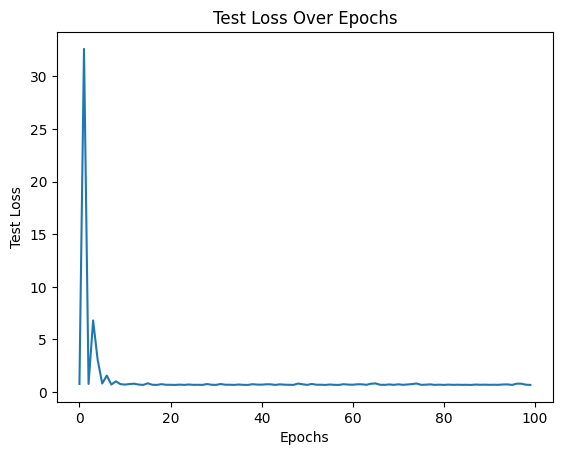

In [11]:
# Run the main function
if __name__ == "__main__":

    #print('OPTIONS ', options)
    # Tuning Parameters:
    import easydict
    from argparse import ArgumentParser
    parser = ArgumentParser()
    args = parser.parse_known_args()[0]
    #使用 easydict，可以创建一个命名空间对象，该对象具有字典的功能，并允许通过点号操作符来访问和设置键值对。
    args = easydict.EasyDict({
            "num_epochs": 100,
            "batch_size": 1,
            "lr": 0.0005,
            "tb_dir": "./runs",
            "final": False,
            "max_pool": False,
            "embedding_size" : 1024,
            "vocab_size" : 50000,
            "max_length" : 520,
            "num_heads" : 2,
            "depth" : 2,
            "seed" : 1,
            "lr_warmup" : 500,
            "gradient_clipping" : 1.0
    })
    evaluation = go(args)

    epoch_numbers = evaluation['epoch']
    test_accuracies = evaluation['Test Accuracy']

    # 将数据转换为 NumPy 数组
    epoch_numbers = np.array(epoch_numbers)
    test_accuracies = np.array(test_accuracies)

    # 获取排序后的索引
    sorted_indices = np.argsort(epoch_numbers)

    # 根据排序后的索引获取排序后的数据
    sorted_epoch_numbers = epoch_numbers[sorted_indices]
    sorted_test_accuracies = test_accuracies[sorted_indices]

    # 绘制迭代MSE折线图
    plt.plot(sorted_epoch_numbers, sorted_test_accuracies)
    plt.xlabel('Epochs')
    plt.ylabel('Test Loss')  # 或者 'Test Accuracy'，具体根据你的情况来确定
    plt.title('Test Loss Over Epochs')
    plt.show()